In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from setup_problem import load_problem
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams['figure.figsize'] = [15, 10]
np.random.seed(1337)

# Load and Featurize Dataset

In [3]:
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem('lasso_data.pickle')
x_train_featurized, x_val_featurized = featurize(x_train), featurize(x_val)

# 2. Ridge Regression

## 2.1

In [4]:
from ridge_regression import RidgeRegression as Ridge
from sklearn.metrics import mean_squared_error

100%|██████████| 50/50 [00:36<00:00,  1.13it/s]


Text(0, 0.5, 'Mean Squared Error')

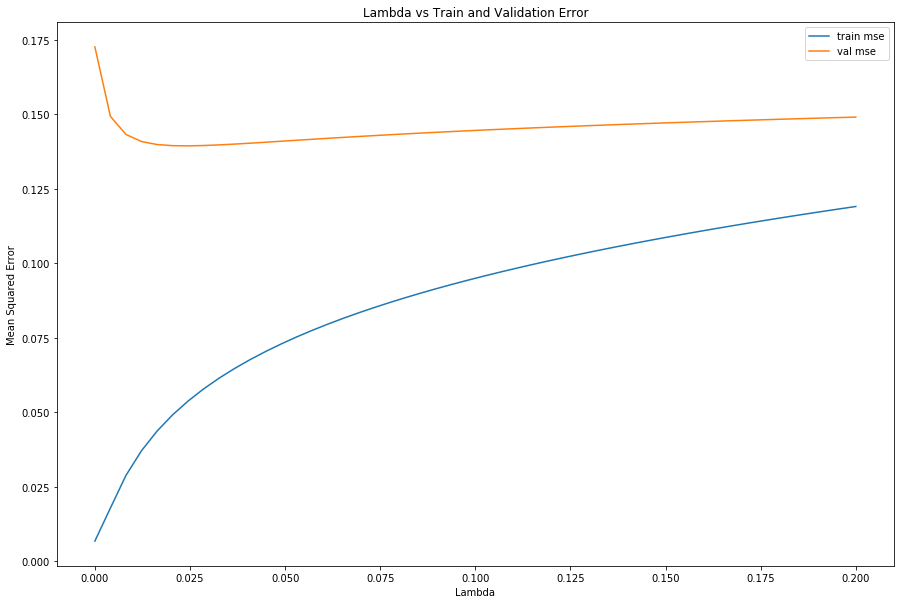

In [5]:
lambdas = np.linspace(0,0.2, 50)
train_error = []
val_error = []
for l in tqdm(lambdas):
    model = Ridge(l)
    model.fit(x_train_featurized, y_train)
    train_error.append(mean_squared_error(y_train, model.predict(x_train_featurized)))
    val_error.append(mean_squared_error(y_val, model.predict(x_val_featurized)))
    
results = pd.DataFrame({
    'lambda': lambdas,
    'train_error': train_error,
    'val_error': val_error
})

plt.plot(lambdas, train_error, label='train mse')
plt.plot(lambdas, val_error, label='val mse')
plt.legend()
plt.title("Lambda vs Train and Validation Error")
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')

In [6]:
# Table of the results
results

,lambda,train_error,val_error
0,0.000000,0.006752,0.172592
1,0.004082,0.017843,0.149295
2,0.008163,0.028775,0.143205
3,0.012245,0.037058,0.140837
4,0.016327,0.043637,0.139837
5,0.020408,0.049084,0.139448
6,0.024490,0.053738,0.139384
7,0.028571,0.057810,0.139497
8,0.032653,0.061431,0.139709
9,0.036735,0.064689,0.139979


## 2.2

Text(0.5, 1.0, 'Comparison of Various Models to Target Function')

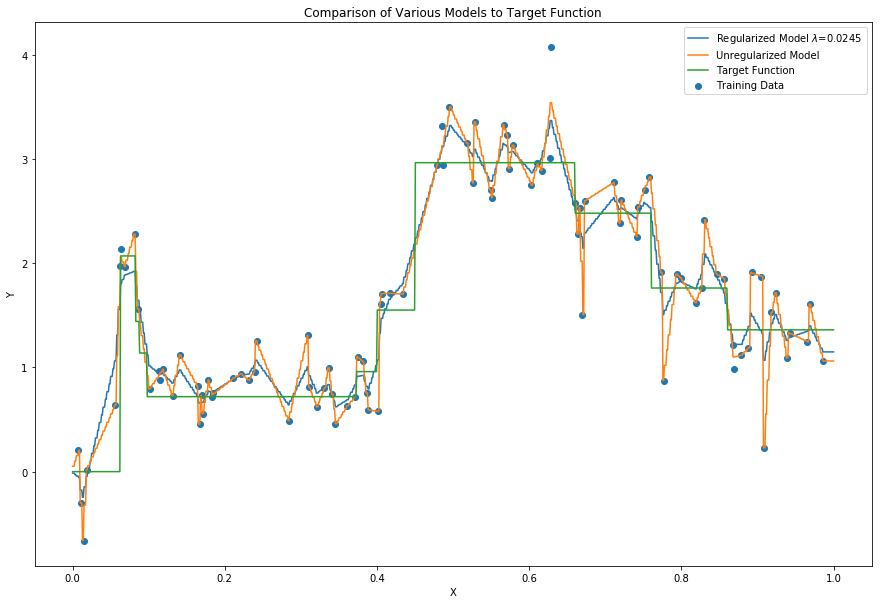

In [7]:
# Get best value for lambda
l = lambdas[np.argmin(val_error)]
best_model = Ridge(l).fit(x_train_featurized, y_train)
unreg_model = Ridge(0).fit(x_train_featurized, y_train)

x = np.linspace(0,1,1000)
x_featurized = featurize(x)

plt.scatter(x_train, y_train, label='Training Data')
plt.plot(x, best_model.predict(x_featurized), label='Regularized Model $\lambda$={}'.format(round(l,4)))
plt.plot(x, unreg_model.predict(x_featurized), label='Unregularized Model')
plt.plot(x, target_fn(x), label='Target Function')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Comparison of Various Models to Target Function")

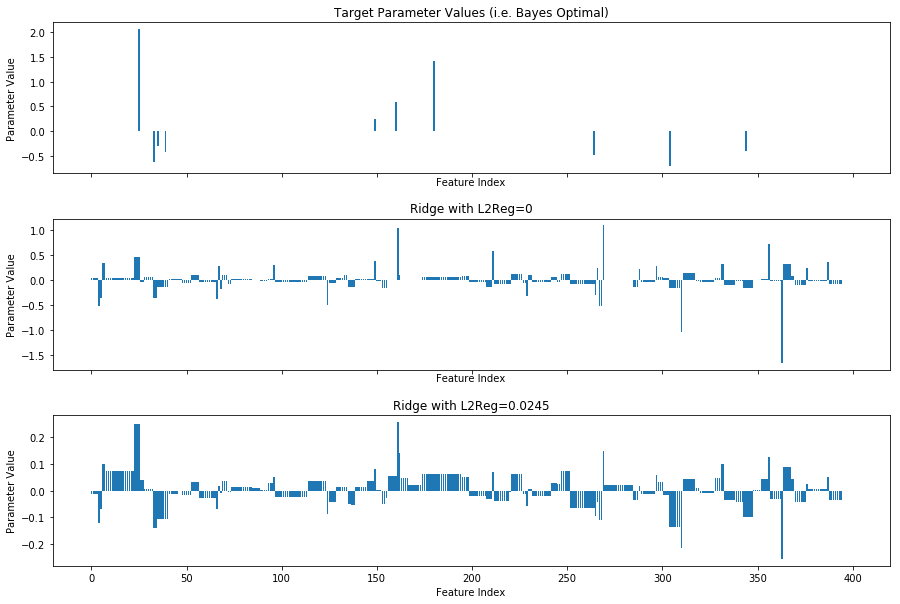

In [8]:
from ridge_regression import compare_parameter_vectors
pred_fns = []
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true})
pred_fns.append({"name":'Ridge with L2Reg=0', "coefs":unreg_model.w_})
pred_fns.append({"name":'Ridge with L2Reg={}'.format(round(l,4)), "coefs":best_model.w_})

fig = compare_parameter_vectors(pred_fns)

With increased regularization we see the scale of the coefficients decrease. It appears that the coefficients with the most weight remain the same, it is only the size of these weights that differ. The graph also shows that the difference in weights between the most important features and other features decreases as regularization is increased.

## 2.3

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
coef_true_binary = (np.abs(coefs_true) > 0).astype(int)

In [11]:
thresholds = [1e-6, 1e-3, 1e-2, 5e-2, 1e-1]
coef_preds = []
for t in thresholds:
    pred = (np.abs(best_model.w_) >= t).astype(int)
    coef_preds.append(pred)

In [12]:
for thresh, pred in zip(thresholds, coef_preds):
    print('Threshold = {}'.format(thresh))
    print(confusion_matrix(pred, coef_true_binary))
    print()

Threshold = 1e-06
[[  5   0]
 [385  10]]

Threshold = 0.001
[[ 11   0]
 [379  10]]

Threshold = 0.01
[[ 53   0]
 [337  10]]

Threshold = 0.05
[[277   0]
 [113  10]]

Threshold = 0.1
[[369   5]
 [ 21   5]]



# 3. Coordinate Descent for Lasso

## 3.1 Experiments with the Shooting Algorithm

### 3.1.1 
Give an expression for computing
 $a_{j}$ and $c_{j}$ using matrix and vector operations, without
 explicit loops.
 
 
\begin{align}
a_j &= 2X_j^T X_j\\
c_j &= 2(y-Xw + w_j X_j)X_j^T
\end{align}

### 3.1.2
Write a function that computes the Lasso solution for a give $\lambda$ using the shooting algorithm described above. For convergence criteria, continue coordinate descent until a pass through
the coordinates reduces the objective function by less than 10−8
, or you have taken 1000
passes through the coordinates. Compare performance of cyclic coordinate descent to
randomized coordinate descent, where in each round we pass through the coordinates in a
different random order (for your choices of λ). Compare also the solutions attained
(following the convergence criteria above) for starting at 0 versus starting at the ridge
regression solution suggested by Murphy (again, for your choices of λ). If you like, you may
adjust the convergence criteria to try to attain better results (or the same results faster).

In [13]:
def shuffle(X, y):
    tmp = np.hstack((X, y.reshape((len(y),1))))
    np.random.shuffle(tmp)
    return tmp[:,:-1], tmp[:, -1]

def lasso_loss(X, y, w, l):
    # Compute the lasso loss
    return sum(np.square(np.matmul(X, w) - y)) + l*sum(np.abs(w))

def soft(a, b):
    c = np.abs(a) - b
    c_plus = c if c >=0 else 0
    return np.sign(a)*c_plus

In [14]:
def compute_lasso_solution(X, y, l, thresh=1e-8, max_iter=1000, w_init=False, randomized=False):
    """
    Args:
        X: self-explanatory
        y: self-explanatory
        thresh (float): stop optimization if loss reduction is less than this.
        max_iter (int): max iterations through coordinates before stopping optimization.
        init_ridge (bool): if True, initialize weights with Ridge regression solution.
        randomized (bool): if True, shuffle data at epoch end.
        
    Returns:
        w (numpy array): self-explanatory
    """
    
    n_iter = 0
    n_cols = X.shape[1]
    cols = list(range(n_cols))
    
    if w_init == 'ridge':
        w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X) + l*np.eye(n_cols)), X.T), y)
    elif w_init is False:
        w = np.zeros(n_cols)
    else:
        w = w_init
        
    old_loss = lasso_loss(X, y, w, l)
    delta_loss = thresh + 1
    
    
    while n_iter <= max_iter and delta_loss > thresh:  
        if randomized:
            np.random.shuffle(cols)         
        for j in cols:
            X_j = X[:,j]
            if not X_j.any():
                # Edge case if column is all 0
                w[j] = 0
            else:
                a = 2 * np.matmul(X_j.T, X_j)
                c = 2 * np.matmul((y - np.matmul(X, w) + w[j]*X_j).T, X_j)
                w[j] = soft(c/a, l/a)         
        # end of iteration / epoch
        n_iter += 1
        new_loss = lasso_loss(X, y, w, l)
        delta_loss = old_loss - new_loss
        old_loss = new_loss
    return w
            

#### Cyclic vs Randomized Coordinate Descent

In [15]:
%timeit compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-3, randomized=True)

2.84 s ± 974 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-3, randomized=False)

2.91 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It appears that randomized coordinate descent converges faster.

#### Effect of solution initialization.

In [17]:
%timeit compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-3, randomized=True, w_init='ridge')

899 ms ± 32.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-3, randomized=True, w_init=False)

1.78 s ± 329 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
w_init = compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-8, randomized=True, w_init='ridge')
w = compute_lasso_solution(x_train_featurized, y_train, 1, thresh=1e-8, randomized=True, w_init=False)

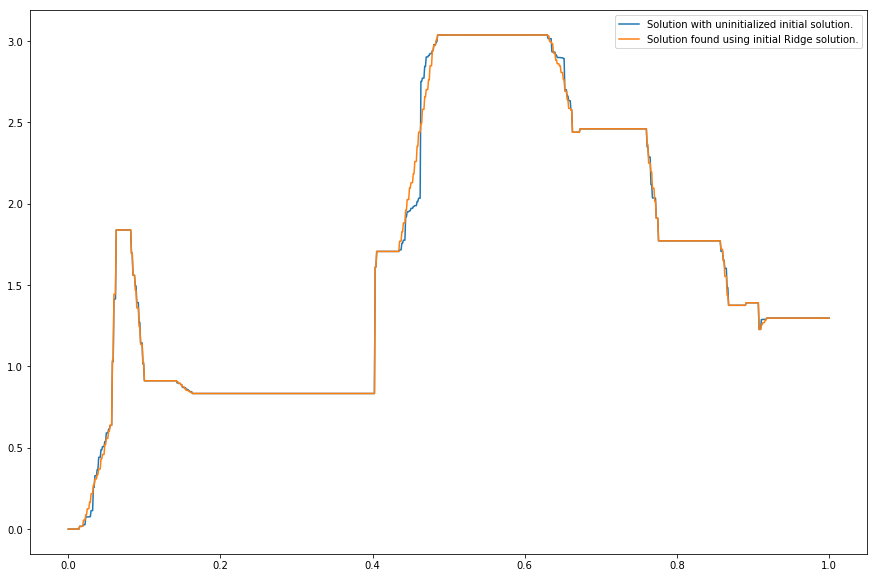

In [30]:
plt.plot(x, np.matmul(x_featurized, w), label='Solution with uninitialized initial solution.')
plt.plot(x, np.matmul(x_featurized, w_init), label='Solution found using initial Ridge solution.')
plt.legend()

Looking at the timings, we can see that initializing the solution with the Ridge solution results in much faster convergence. Also, by plotting the solutions we can see that both methods result in very similar solutions.

### 3.1.3
Run your best Lasso configuration on the training dataset provided, and select the λ that
minimizes the square error on the validation set. Include a table of the parameter values you
tried and the validation performance for each. Also include a plot of these results. Include
also a plot of the prediction functions, just as in the ridge regression section, but this time
add the best performing Lasso prediction function and remove the unregularized least
squares fit. Similarly, add the lasso coefficients to the bar charts of coefficients generated in
the ridge regression setting. Comment on the results, with particular attention to parameter
sparsity and how the ridge and lasso solutions compare. What’s the best model you found,
and what’s its validation performance?

In [21]:
lambdas = [1e-2, 1e-1, 1, 2, 5]
train_losses = []
val_losses = []
best_ridge = best_model
weights = []

for l in lambdas:
    w = compute_lasso_solution(x_train_featurized, y_train, l, thresh=1e-8, randomized=True, w_init='ridge')
    train_preds = np.matmul(x_train_featurized, w)
    val_preds = np.matmul(x_val_featurized, w)
    train_losses.append(mean_squared_error(train_preds, y_train))
    val_losses.append(mean_squared_error(val_preds, y_val))
    weights.append(w)

#### Table of Parameter Search Results

In [22]:
l_search_results = pd.DataFrame({
    'lambda': lambdas,
    'train_mse': train_losses,
    'val_mse': val_losses
})
l_search_results

,lambda,train_mse,val_mse
0,0.01,0.006805,0.170998
1,0.10,0.011139,0.158850
2,1.00,0.091950,0.126596
3,2.00,0.105366,0.129889
4,5.00,0.170150,0.160504


Text(0, 0.5, 'Mean Squared Error')

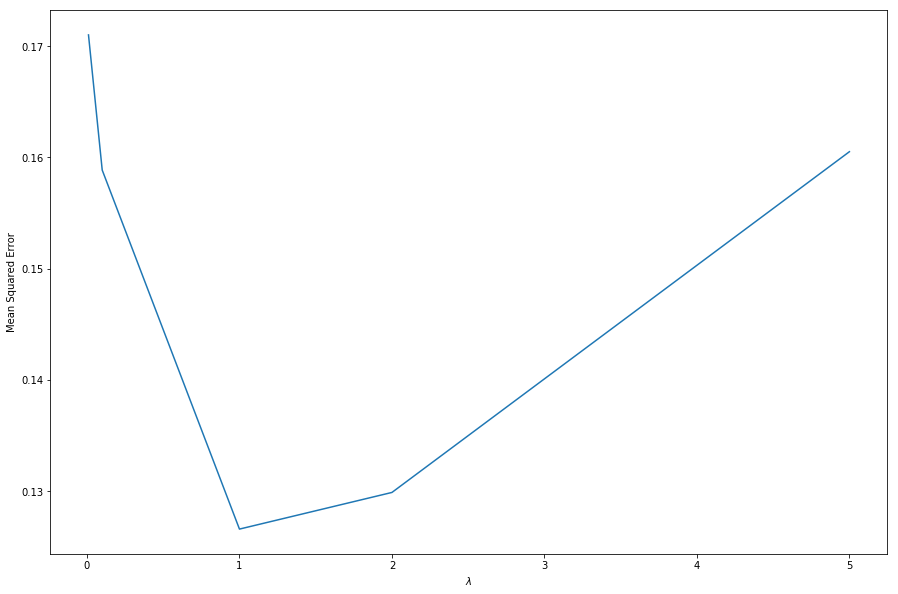

In [23]:
plt.plot(l_search_results['lambda'], l_search_results.val_mse)
plt.xlabel('$\lambda$')
plt.ylabel('Mean Squared Error')

In [24]:
best_lasso_w = weights[np.argmin(val_losses)]
l = lambdas[np.argmin(val_losses)]

#### Comparison of Lasso and Ridge to Target Function

Text(0.5, 1.0, 'Comparison of Various Models to Target Function')

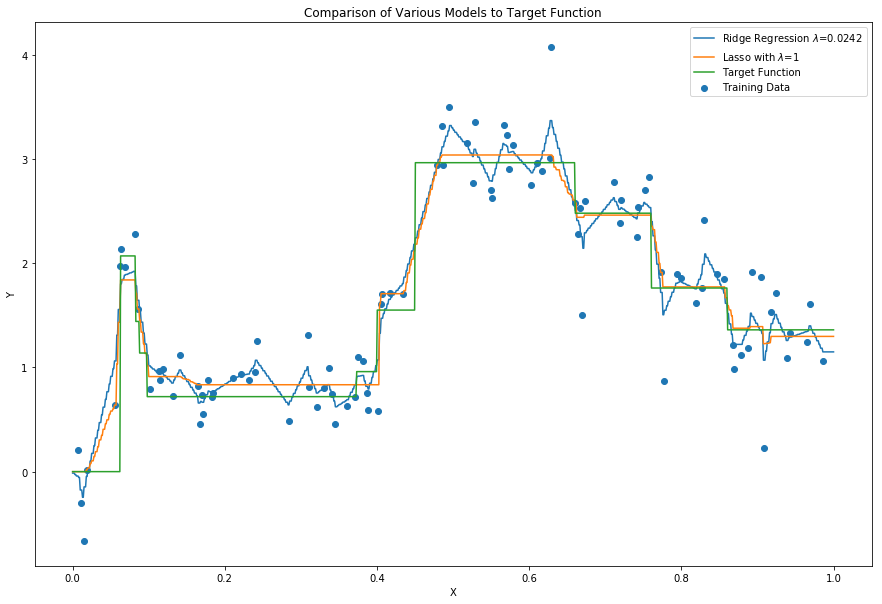

In [25]:
plt.scatter(x_train, y_train, label='Training Data')
plt.plot(x, best_ridge.predict(x_featurized), label='Ridge Regression $\lambda$=0.0242')
plt.plot(x, np.matmul(x_featurized, best_lasso_w), label='Lasso with $\lambda$=1')
plt.plot(x, target_fn(x), label='Target Function')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Comparison of Various Models to Target Function")

#### Coefficient Chart

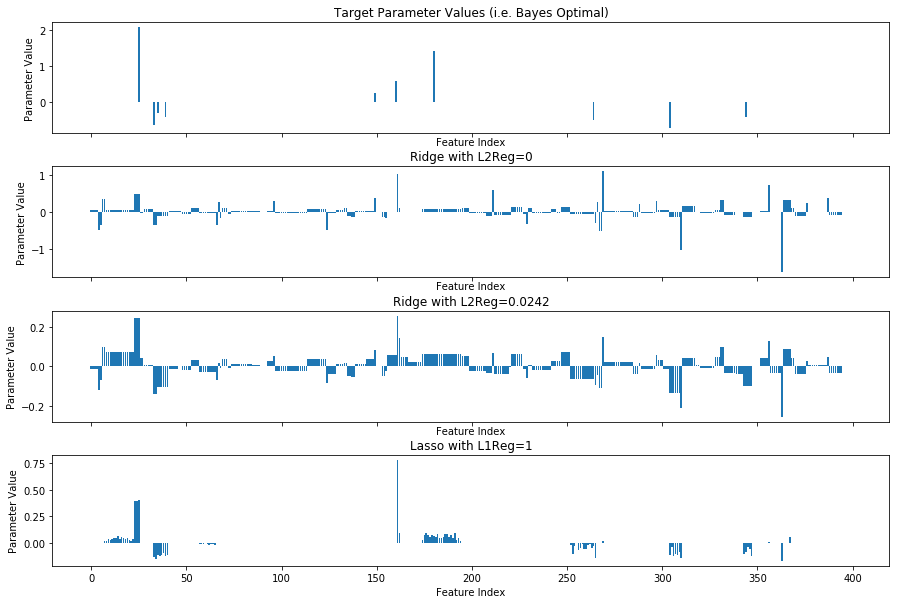

In [26]:
pred_fns = []
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true})
pred_fns.append({"name":'Ridge with L2Reg=0', "coefs":unreg_model.w_})
pred_fns.append({"name":'Ridge with L2Reg={}'.format(0.0242), "coefs":best_model.w_})
pred_fns.append({"name":'Lasso with L1Reg=1', "coefs":best_lasso_w})
fig = compare_parameter_vectors(pred_fns)

#### Comparison of Lasso to Ridge Performance

In [27]:
lasso_losses = min(val_losses)
ridge_loss = mean_squared_error(best_ridge.predict(x_val_featurized), y_val)
print("Lasso model loss: {} \nRidge model loss: {}".format(lasso_losses, ridge_loss))

Lasso model loss: 0.1265958720525034 
Ridge model loss: 0.13938409974459445


Lasso regression resulted in a much sparser solution. In addition, using the lasso loss resulted in improved performance as measured by mean squared error. It outperformed ridge with a mse of 0.126. Also, in this particular case, the lasso solution better exhibits certain characteristics of the Bayes optimal solution such as its sparsity and step function resembelence.

### 3.1.4
Implement the homotopy method described above.
 Plot the results (average validation loss vs λ).

In [31]:
l_max = 2 * np.linalg.norm(np.matmul(x_train_featurized.T, y_train), ord=np.inf)
lambdas = [l_max * 0.8**i for i in range(30)]
val_losses = []

w = 'ridge'
for l in lambdas:
    w = compute_lasso_solution(x_train_featurized, y_train, l, thresh=1e-8, randomized=True, w_init=w)
    val_preds = np.matmul(x_val_featurized, w)
    val_losses.append(mean_squared_error(val_preds, y_val))

Text(0.5, 1.0, 'Regularization Path')

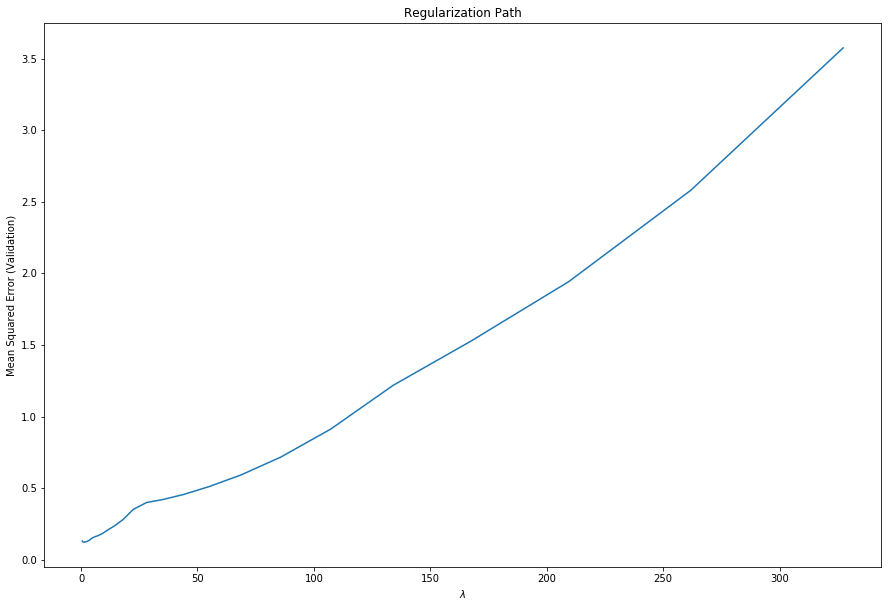

In [32]:
plt.plot(lambdas, val_losses)
plt.xlabel('$\lambda$')
plt.ylabel('Mean Squared Error (Validation)')
plt.title("Regularization Path")

### 3.1.5
Note that the data in Figure 1 is almost entirely nonnegative. Since we don’t have
an unregularized bias term, we have “pay for” this offset using our penalized parameters. Note
also that λmax would decrease significantly if the y values were 0 centered (using the training
data, of course), or if we included an unregularized bias term. Experiment with one or both
of these approaches, for both and lasso and ridge regression, and report your findings

We will try centering the y values

In [33]:
y_mean = y_train.mean()
y_train_trans = y_train - y_mean
y_val_trans = y_val - y_mean

l_max_trans = 2 * np.linalg.norm(np.matmul(x_train_featurized.T, y_train_trans), ord=np.inf)
print("With 0 centered y values, l_max = {}".format(l_max_trans))

With 0 centered y values, l_max = 66.51995371985255


In [44]:
lambdas_trans = [l_max_trans * 0.8**i for i in range(30)]
val_losses_centered = []

w = 'ridge'
for l in lambdas_trans:
    w = compute_lasso_solution(x_train_featurized, y_train_trans, l, thresh=1e-8, randomized=True, w_init=w)
    val_preds = np.matmul(x_val_featurized, w)
    val_losses_centered.append(mean_squared_error(val_preds, y_val_trans))   

Text(0.5, 1.0, 'Regularization Path (Centered Y Values)')

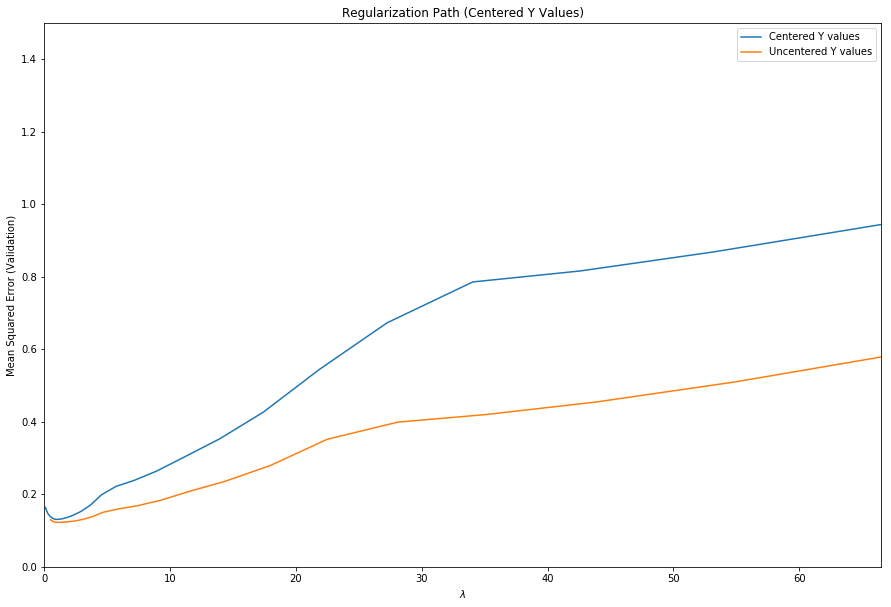

In [38]:
plt.plot(lambdas_trans, val_losses_centered, label='Centered Y values')
plt.plot(lambdas, val_losses, label='Uncentered Y values')
plt.xlim(0, max(lambdas_trans))
plt.ylim(0,1.5)
plt.xlabel('$\lambda$')
plt.legend()
plt.ylabel('Mean Squared Error (Validation)')
plt.title("Regularization Path (Centered Y Values)")

In [39]:
best_ridge.fit(x_train_featurized, y_train_trans)
w_lasso = compute_lasso_solution(x_train_featurized, y_train_trans, 1, thresh=1e-8, randomized=True, w_init='ridge')

Text(0.5, 1.0, 'Comparison of Various Models to Target Function (Centered Y Values)')

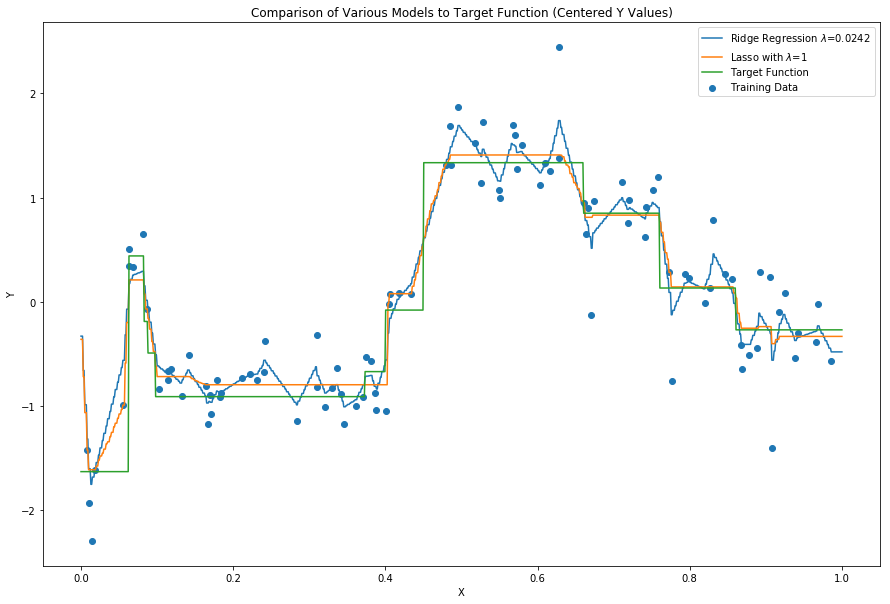

In [40]:
plt.scatter(x_train, y_train_trans, label='Training Data')
plt.plot(x, best_ridge.predict(x_featurized), label='Ridge Regression $\lambda$=0.0242')
plt.plot(x, np.matmul(x_featurized, w_lasso), label='Lasso with $\lambda$=1')
plt.plot(x, target_fn(x) - y_mean, label='Target Function')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Comparison of Various Models to Target Function (Centered Y Values)")

Using centered y values did decrease lambda_max from around 330 to 66. The best solutions do not appear to differ much from the best solution using uncentered y values. However, looking at the regularization path for lasso regression, we see that using the centered y values results in higher mean squared error outside of the optimal lambda values.

## 3.2 Deriving the Coordinate Minimizer for Lasso ------------------------------------------------------------------------------------------

### 3.2.1 ------------------------------------------------------------------------------------------------------------------------------------------
First let's get a trivial case out of the way. If $x_{ij}=0$ for
 $i=1,\ldots,n$, what is the coordinate minimizer $w_{j}$?

When $X_j=0$, we have $f(w_j) = \sum_{i=1}^n  y_i^2 + \lambda \vert w_j \vert + \lambda \sum_{k\neq j}\vert w_k \vert$. It is trivial to see that, with respect to $w_j$, this is minimized when $w_j=0$

### 3.2.2 ------------------------------------------------------------------------------------------------------------------------------------------
Give an expression for the derivative $f(w_{j})$ for $w_{j}\neq0$.

\begin{align}
f'(w_j)& = 2\sum_{i=1}^n \bigg[ ( w_j x_{ij} + \sum_{k\neq j}w_kx_{ik} - y_i)x_{ij} \bigg] + \lambda sign(w_j)\\
&= 2w_j \sum_{i=1}^n x_{ij}^2 - 2\sum_{i=1}^n w_k x_{ij} (y_i - \sum_{k\neq j} w_k x_{ik}) + \lambda sign(w_j)\\
&= w_ja_j - c_j + \lambda sign(w_j)
\end{align}

### 3.2.3 ------------------------------------------------------------------------------------------------------------------------------------------
If $w_{j}>0$ and minimizes $f$, show that $w_{j}=\frac{1}{a_{j}}\left(c_{j}-\lambda\right)$.
 Similarly, if $w_{j}<0$ and minimizes $f$, show that $w_{j}=\frac{1}{a_{j}}\left(c_{j}+\lambda\right)$.
 Give conditions on $c_{j}$ that imply that a minimizer $w_{j}$ is
 positive and conditions for which a minimizer $w_{j}$ is negative.

Assume that $w_j \neq 0$ and minimizes $f$. Then 
\begin{align}
f'(w_j) &= 0\\
w_ja_j - c_j + \lambda sign(w_j) &= 0\\
w_j a_j &= c_j - \lambda sign(w_j) \\
w_j &= \frac{1}{a_j}(c_j - \lambda sign(w_j))
\end{align}

Now its clear that if $w_j > 0$
\begin{align}
w_j &= \frac{1}{a_j}(c_j - \lambda)
\end{align}
And if $w_j < 0$
\begin{align}
w_j &= \frac{1}{a_j}(c_j + \lambda)
\end{align}

Now its clear that with respect to $c_j\,\,$, $w_j > 0$ when $c_j > \lambda$

And $w_j < 0$ when $c_j < -\lambda$


### 3.2.4 ------------------------------------------------------------------------------------------------------------------------------------------
Derive expressions for the two one-sided derivatives at $f(0)$, and
 show that $c_{j}\in\left[-\lambda,\lambda\right]$ implies that $w_{j}=0$
 is a minimizer.

$ \lim_{\epsilon\downarrow0}\frac{f(\epsilon)-f(0)}{\epsilon}\ge0\quad\mbox{and}\quad\lim_{\epsilon\downarrow0}\frac{f(- \epsilon)-f(0)}{\epsilon}\ge0.$

\begin{align}
\lim_{\epsilon\downarrow0}\frac{f(\epsilon)-f(0)}{\epsilon} &= \lim_{\epsilon\downarrow0} \frac{1}{\epsilon} \bigg[ \sum_{i=1}^n \big( \epsilon x_{ij} + \sum_{k\neq j} w_k x_{ik} - y_i \big)^2 + \lambda \vert \epsilon \vert + \lambda \sum_{k\neq j} \vert w_j \vert  - \sum_{i=1}^n \big( \sum_{k\neq j} w_k x_{ik} - y_i \big)^2  -\lambda \sum_{k\neq j} \vert w_j \vert  \bigg] \\
&= \lim_{\epsilon\downarrow0} \frac{1}{\epsilon} \bigg[ \sum_{i=1}^n \bigg( \epsilon^2 x_{ij}^2 + 2\epsilon x_{ij} \big(\sum_{k\neq j}w_k x_{ik} - y_i \big) + \big( \sum_{k\neq j} w_k x_{ik} - y_i \big)^2 \bigg) + \lambda \vert \epsilon \vert - \big( \sum_{k\neq j} w_k x_{ik} - y_i \big)^2 \bigg] \\
&= \lim_{\epsilon\downarrow0}  \bigg[ \sum_{i=1}^n \bigg( \epsilon x_{ij}^2 + 2 x_{ij} \big(\sum_{k\neq j}w_k x_{ik} - y_i \big) \bigg) + \lambda \vert \epsilon \vert  \bigg] \\
&=  \sum_{i=1}^n \bigg( 2 x_{ij} \big(\sum_{k\neq j}w_k x_{ik} - y_i \big) \bigg) + \lambda  \\
&= \lambda - c_j
\end{align}

\begin{align}
\lim_{\epsilon\downarrow0}\frac{f(-\epsilon)-f(0)}{\epsilon} &= \lim_{\epsilon\downarrow0} \frac{1}{\epsilon} \bigg[ \sum_{i=1}^n \big( -\epsilon x_{ij} + \sum_{k\neq j} w_k x_{ik} - y_i \big)^2 + \lambda \vert -\epsilon \vert + \lambda \sum_{k\neq j} \vert w_j \vert  - \sum_{i=1}^n \big( \sum_{k\neq j} w_k x_{ik} - y_i \big)^2  -\lambda \sum_{k\neq j} \vert w_j \vert  \bigg] \\
&= \lim_{\epsilon\downarrow0} \frac{1}{\epsilon} \bigg[ \sum_{i=1}^n \bigg( \epsilon^2 x_{ij}^2 - 2\epsilon x_{ij} \big(\sum_{k\neq j}w_k x_{ik} - y_i \big) + \big( \sum_{k\neq j} w_k x_{ik} - y_i \big)^2 \bigg) + \lambda \vert \epsilon \vert - \big( \sum_{k\neq j} w_k x_{ik} - y_i \big)^2 \bigg] \\
&= \lim_{\epsilon\downarrow0}  \bigg[ \sum_{i=1}^n \bigg( \epsilon x_{ij}^2 - 2 x_{ij} \big(\sum_{k\neq j}w_k x_{ik} - y_i \big) \bigg) + \lambda \vert \epsilon \vert  \bigg] \\
&=  \sum_{i=1}^n \bigg( -2 x_{ij} \big(\sum_{k\neq j}w_k x_{ik} - y_i \big) \bigg) + \lambda  \\
&= \lambda + c_j
\end{align}

Note that if $c_{j}\in\left[-\lambda,\lambda\right]$ then $\lambda + c_j \geq 0$ and $\lambda - c_j \geq 0$. Thus $ \lim_{\epsilon\downarrow0}\frac{f(\epsilon)-f(0)}{\epsilon}\ge0$ and $\lim_{\epsilon\downarrow0}\frac{f(- \epsilon)-f(0)}{\epsilon}\ge0.$ Thus $w_j=0$ is a minimizer.

### 3.2.5 ------------------------------------------------------------------------------------------------------------------------------------------

Putting together the preceding results, we conclude the following:
 \begin{align}
 w_{j}=\begin{cases}
 \frac{1}{a_{j}}\left(c_{j}-\lambda\right) & c_{j}>\lambda\\
 0 & c_{j}\in[-\lambda,\lambda]\\
 \frac{1}{a_{j}}\left(c_{j}+\lambda\right) & c_{j}<-\lambda
 \end{cases}
 \end{align}
 Show that this is equivalent to the expression given in 

#### Case 1: $c_{j}\in\left[-\lambda,\lambda\right]$
Note that 
\begin{align}
soft\bigg(\frac{c_j}{a_j}, \frac{\lambda}{a_j}\bigg) = sign\bigg(\frac{c_j}{a_j}\bigg) \bigg( \bigg\vert\frac{c_j}{a_j}\bigg\vert - \frac{\lambda}{a_j}\bigg)_+
\end{align}
But
\begin{align}
\vert c_j \vert - \lambda \leq 0\\
and \\
a_j \geq 0
\end{align}

Thus $ \bigg\vert\frac{c_j}{a_j}\bigg\vert - \frac{\lambda}{a_j} \leq0$ and so $soft\bigg(\frac{c_j}{a_j}, \frac{\lambda}{a_j}\bigg) = 0$

#### Case 2 $c_j \geq \lambda$
Since $c_j\geq0$ and $a_j \geq0$

\begin{align}
soft\bigg(\frac{c_j}{a_j}, \frac{\lambda}{a_j}\bigg) &= sign\bigg(\frac{c_j}{a_j}\bigg) \bigg( \bigg\vert\frac{c_j}{a_j}\bigg\vert - \frac{\lambda}{a_j}\bigg)_+ \\
&= \bigg( \frac{c_j - \lambda}{a_j} \bigg)\\
\end{align}

#### Case 3 $c_j \leq -\lambda$
Since $c_j\leq0$ and $a_j \geq0$

\begin{align}
soft\bigg(\frac{c_j}{a_j}, \frac{\lambda}{a_j}\bigg) &= sign\bigg(\frac{c_j}{a_j}\bigg) \bigg( \bigg\vert\frac{c_j}{a_j}\bigg\vert - \frac{\lambda}{a_j}\bigg)_+ \\
&= -\bigg( \frac{\vert c_j\vert - \lambda}{a_j} \bigg)\\
&= \frac{-\vert c_j\vert + \lambda}{a_j} \\
&= \frac{c_j + \lambda}{a_j} && \text{Since $c_j\leq0$.}
\end{align}

# 4 Lasso Properties ---------------------------------------------------------------------------------------------------------

## 4.1 Deriving $\lambda_{max}$

### 4.1.1 -------------------------------------------------------------------------------------------------------------------------------------------------
Compute $J'(0;v)$. That is, compute the one-sided directional derivative
 of $J(w)$ at $w=0$ in the direction $v$. [Hint: the result should
 be in terms of $X,y,\lambda,\text{ and }v$.]

\begin{align}
J'(0:v) &= \lim_{h\downarrow 0} \frac{J(hv) - J(0)}{h}\\
&= \lim_{h\downarrow0} \frac{\|hXv-y\|_2^2 + \lambda h - \|-y\|_2^2}{h}\\
&= \lim_{h\downarrow0} \frac{h^2 \|Xv\|_2^2 -2h(Xv)^T y + \lambda h}{h}\\
&= \lim_{h\downarrow0} h \|Xv\|_2^2 -2(Xv)^T y + \lambda\\
&= \lambda -2(Xv)^T y
\end{align}

### 4.1.2 -------------------------------------------------------------------------------------------------------------------------------------------------
Show that for any $v\neq0$, we have $J'(0;v)\ge0$
 if and only if $\lambda\ge C$, for some $C$ that depends on $X,y,\text{ and }v$.

\begin{align}
J'(0:v) &\geq 0\\
\lambda -2(Xv)^T y &\geq 0\\
\lambda &\geq 2(Xv)^T y
\end{align}

Thus
\begin{align}
C = 2(Xv)^T y
\end{align}

### 4.1.3 -------------------------------------------------------------------------------------------------------------------------------------------------
In the previous problem, we get a different lower bound on $\lambda$
 for each choice of $v$. Show that the maximum of these lower bounds
 on $\lambda$ is $\lambda_{\text{max}}=2\|X^{T}y\|_{\infty}$. Conclude
 that $w=0$ is a minimizer of $J(w)$ if and only if $\lambda\ge2\|X^{T}y\|_{\infty}$

#### 4.1.3.1 Prove that $\lambda_{\text{max}}=2\|X^{T}y\|_{\infty}$
Observe that 
\begin{align}
C &= 2v^TX^Ty\\
&= 2\sum_{i=1}^{d}v_i(X^Ty)_i && \text{subject to $\|v\|_1 = 1$}
\end{align}

From here it should be clear that $C \leq 2\|X^{T}y\|_{\infty}$ and that $C = 2\|X^{T}y\|_{\infty}$ when $v=e_j$ where $j$ is the index of $2\|X^{T}y\|_{\infty}$ in $X^Ty$.\\

Thus $\lambda_{\text{max}}=2\|X^{T}y\|_{\infty}$.


#### 4.2.3.1 Conclude that $w=0$ is a minimizer of $J(w)$ if and only if $\lambda\ge2\|X^{T}y\|_{\infty}$

Assume that $w=0$ is a minimizer of $J(w)$. Then it follows that $J'(0;v)\ge0\,\, \forall\,\, v \neq 0$. From 4.1.2 we know that $J'(0;v)\ge0$ when $\lambda \geq 2(Xv)^Ty$. But from 4.1.3.1 we have $2(Xv)^Ty \leq 2\|X^{T}y\|_{\infty}$. Thus $J'(0;v)\ge0\,\, \forall\,\, v \neq 0$ when $\lambda \geq 2\|X^{T}y\|_{\infty}$

Now assume that $\lambda \geq 2\|X^{T}y\|_{\infty}$. Then $\lambda \geq 2(Xv)^Ty\,\, \forall\,\, v\neq0$. Then by 4.1.2 we have $J'(0;v)\ge0\,\, \forall\,\, v \neq 0$ and so $w=0$ is a minimizer of $J(w)$

### 4.1.4 -------------------------------------------------------------------------------------------------------------------------------------------------
Let $J(w,b)=\left\Vert Xw+b\mathbf{1}-y\right\Vert _{2}^{2}+\lambda\left\Vert w\right\Vert _{1}$,
 where $\mathbf{1}\in \!R^{n}$ is a column vector of $1$'s. Let
 $\bar{y}$ be the mean of values in the vector $y$. Show that $(w^{*},b^{*})=(0,\bar{y})$
 is a minimizer of $J(w,b)$ if and only if $\lambda\ge\lambda_{\text{max}}=2\|X^{T}(y- \bar{y})\|_{\infty}$.

#### Part 1
Observe that 
\begin{align}
J'(0, \bar{y}:v) &= \lim_{h\downarrow 0} \frac{J(hv, \bar{y}) - J(0, \bar{y})}{h}\\
&= \lim_{h\downarrow0} \frac{\|hXv+(\bar{y}-y)\|_2^2 + \lambda h - \|\bar{y}-y\|_2^2}{h}\\
&= \lim_{h\downarrow0} \frac{h^2 \|Xv\|_2^2 -2h(Xv)^T (\bar{y}-y) + \lambda h}{h}\\
&= \lim_{h\downarrow0} h \|Xv\|_2^2 -2(Xv)^T (\bar{y}-y) + \lambda\\
&= \lambda -2(Xv)^T (y-\bar{y})
\end{align}

#### Part 2
We now claim that for any $v\neq0$, we have $J'(0, \bar{y};v)\ge0$
 if and only if $\lambda\ge C$, for some $C$ that depends on $X,y, \bar{y},\text{ and }v$
 
Observe that
\begin{align}
J'(0, \bar{y}:v) &\geq 0\\
\lambda - 2(Xv)^T(y-\bar{y}) &\geq 0\\
\lambda &\geq 2(Xv)^T(y-\bar{y}).
\end{align}

Thus
\begin{align}
C = 2(Xv)^T(y-\bar{y})
\end{align}

#### Part 3
Now prove that $\lambda_{\text{max}}=2\|X^{T}(y-\bar{y})\|_{\infty}$
Observe that 
\begin{align}
C &= 2v^TX^T(y-\bar{y})\\
&= 2\sum_{i=1}^{d}v_i(X^T(y-\bar{y}))_i && \text{subject to $\|v\|_1 = 1$}
\end{align}

From here it should be clear that $C \leq 2\|X^{T}(y-\bar{y})\|_{\infty}$ and that $C = 2\|X^{T}(y-\bar{y})\|_{\infty}$ when $v=e_j$ where $j$ is the index of $2\|X^{T}(y-\bar{y})\|_{\infty}$ in $X^T(y-\bar{y})$.

Thus $\lambda_{\text{max}}=2\|X^{T}(y-\bar{y})\|_{\infty}$.

#### Part 4
Conclude that $(w^{*},b^{*})=(0,\bar{y})$ is a minimizer of $J(w, b)$ if and only if $\lambda\ge2\|X^{T}(y-\bar{y})\|_{\infty}$

Assume that  $(w^{*},b^{*})=(0,\bar{y})$ is a minimizer of $J(w, b)$. Then it follows that $J'(0,\bar{y};v)\ge0\,\, \forall\,\, v \neq 0$. We know that $J'(0,\bar{y};v)\ge0$ when $\lambda \geq 2(Xv)^T(y-\bar{y})$. But $2(Xv)^T(y-\bar{y}) \leq 2\|X^{T}(y-\bar{y})\|_{\infty}$. Thus $J'(0,\hat{y};v)\ge0\,\, \forall\,\, v \neq 0$ when $\lambda \geq 2\|X^{T}(y-\bar{y})\|_{\infty}$

Now assume that $\lambda \geq 2\|X^{T}(y-\bar{y})\|_{\infty}$. Then $\lambda \geq 2(Xv)^T(y-\bar{y})\,\, \forall\,\, v\neq0$. Then we have $J'(0,\bar{y};v)\ge0\,\, \forall\,\, v \neq 0$ and so $(w^{*},b^{*})=(0,\bar{y})$ is a minimizer of $J(w, b)$

## 4.2 Feature Correlation -----------------------------------------------------------------------------------------------------

### 4.2.1 -------------------------------------------------------------------------------------------------------------------------------------------------
Without loss of generality, assume the first two colums of $X$ are
 our repeated features. Partition $X$ and $\theta$ as follows: \\
 \begin{align}
 X=\left(\begin{array}{ccc}
 x_{1} & x_{2} & X_{r}\end{array}\right)\qquad\theta=\left(\begin{array}{c}
 \theta_{1}\\
 \theta_{2}\\
 \theta_{r}
 \end{array}\right)
 \end{align}
 We can write the Lasso objective function as:
 \begin{align*}
 J(\theta)= & \left\Vert X\theta-y\right\Vert _{2}^{2}+\lambda\left\Vert \theta\right\Vert _{1}\\
 = & \left\Vert x_{1}\theta_{1}+x_{2}\theta_{2}+X_{r}\theta_{r}-y\right\Vert _{2}^{2}+ \lambda\vert\theta_{1}\vert+\lambda\vert\theta_{2}\vert+\lambda\left\Vert \theta_{r}\right\Vert _{1}
 \end{align*}
 With repeated features, there will be multiple minimizers of $J(\theta)$.
 Suppose that
 \begin{align}
 \hat{\theta}=\begin{pmatrix}a\\
 b\\
 r
 \end{pmatrix}
 \end{align}
 is a minimizer of $J(\theta)$. Give conditions on $c$ and $d$ such
 that $\left(c,d,r^{T}\right)^{T}$ is also a minimizer of $J(\theta$).
 [Hint: First show that $a$ and $b$ must have the same sign, or
 at least one of them is zero. Then, using this result, rewrite the
 optimization problem to derive a relation between $a$ and $b$.]\\

#### 4.2.1.1 Claim: a and b must both have the same sign or at least one is zero. In other words, $sign(a)sign(b) \geq 0$

Note that since $x_i = x_j$, any solution that minimizes $J(\hat{\theta})$ can be written as
\begin{align}
y = (a+b)x_1 + X_r r
\end{align}

Thus there exists some $k$ that for all solutions, $a+b=k$

Now, again since $x_i = x_j$ ,we can write
\begin{align}
J(\hat{\theta}) &= \|(a+b)x_1 + X_r r - y\|_2^2 + \lambda \vert a \vert + \lambda \vert b \vert + \lambda \| r \|_1
\end{align}

Now let
\begin{align}
F(\hat{\theta}) &= \|(a+b)x_1 + X_r r - y\|_2^2 + \lambda \| r \|_1
\end{align}

Thus
\begin{align}
J(\hat{\theta}) &= F(\hat{\theta}) + \lambda (\vert a \vert + \vert b \vert)
\end{align}

Note that for some $a+b=k$, $F(\hat{\theta})$ is a constant. Thus $J(\hat{\theta})$ is minimized by minimizing $\lambda (\vert a \vert + \vert b \vert)$

Now by the triangle inequality
\begin{align}
\vert a+b \vert \leq \vert a \vert + \vert b \vert
\end{align}

Now $\vert a+b \vert = \vert a \vert + \vert b \vert$ only when $sign(a)sign(b) \geq 0$.

Thus $J(\hat{\theta})$ is minimized when $sign(a)sign(b) \geq 0$.


#### 4.2.1.2 Derive the relation between two possible solutions.

We already showed that a and b must have the same sign, thus
\begin{align}
J(\hat{\theta}) &= \|(a+b)x_1 + X_r r - y\|_2^2 + \lambda \vert a + b \vert + \lambda \| r \|_1
\end{align}

Letting $a+b=k$, its clear to see that $\left(c,d,r^{T}\right)^{T}$ is also a minimizer if $c+d=k=a+b$

### 4.2.2 -------------------------------------------------------------------------------------------------------------------------------------------------
Using the same notation as the previous problem, suppose
 \begin{align}
 \hat{\theta}=\begin{pmatrix}a\\
 b\\
 r
 \end{pmatrix}
 \end{align}
 minimizes the ridge regression objective function. What is the relationship
 between $a$ and $b$, and why? \\

#### Solution:

Let $\phi = \begin{pmatrix}a\\b\end{pmatrix}$

Note then that the ridge regression solution can be written as
\begin{align}
J(\hat{\theta}) &= \|(a+b)x_1 + X_r r - y\|_2^2 + \lambda \|\phi \|_2^2 + \lambda \| r \|_2^2
\end{align}

Thus $J(\hat{\theta})$ is minimized when $a=b$ since $\lambda \|\phi \|_2^2$ is minimized when $a=b$.

# 5. The Ellipsoids in the $l_1 / l_2$ Regularization Picture ------------------------------------------------------

## 5.1 -------------------------------------------------------------------------------------------------------------------------------------------------
Let $\hat{w}=\left(X^{T}X\right)^{-1}X^{T}y$. Show
 that $\hat{w}$ has empirical risk given by
 $
 \hat{R}_{n}(\hat{w})=\frac{1}{n}\left(-y^{T}X\hat{w}+y^{T}y\right)
 $

First note that 
\begin{align}
\hat{w} &= (X^TX^{-1})^{-1}X^Ty\\
&= X^{-1}(X^T)^{-1}X^Ty\\
&= X^{-1}y
\end{align}

Thus 
\begin{align}
\hat{w}^T &= y^T(X^T)^{-1}
\end{align}

Now
\begin{align}
\hat{R}_{n}(\hat{w})&=\frac{1}{n}\left(X\hat{w}-y\right)^{T}\left(X\hat{w}-y\right)\\
&= \frac{1}{n} \left( \hat{w}^T X^T X \hat{w} - \hat{w}^T X^T y - y^T X \hat{w} + y^T y \right)\\
&= \frac{1}{n} \left( \hat{w}^T X^T X \hat{w} - 2y^T X \hat{w} + y^T y \right)\\
&= \frac{1}{n} \left( y^T(X^T)^{-1} X^T X \hat{w} - 2y^T X \hat{w} + y^T y \right)\\
&= \frac{1}{n}\left(-y^{T}X\hat{w}+y^{T}y\right)
\end{align}

## 5.2 -------------------------------------------------------------------------------------------------------------------------------------------------

 Show that for any $w$
 we have
 \begin{align}
 \hat{R}_{n}(w)=\frac{1}{n}\left(w-\hat{w}\right)^{T}X^{T}X\left(w-\hat{w}\right)+\hat{R}_{n}(\hat{w}).
 \end{align}

Recall that $\hat{R}_{n}(\hat{w})=\frac{1}{n}\left(-y^{T}X\hat{w}+y^{T}y\right)$ and $\hat{w}=\left(X^{T}X\right)^{-1}X^{T}y$.

Then
\begin{align}
\hat{R}_{n}(w)&=\frac{1}{n}\left(Xw-y\right)^{T}\left(Xw-y\right)\\
&= \frac{1}{n} \left( w^TX^TXw - 2y^TXw + y^Ty \right)\\
&= \frac{1}{n} \left( w^TX^TXw - 2(X^Ty)^Tw + y^Ty \right)\\
&= \frac{1}{n} \big[ \left( w-(X^TX)^{-1}X^Ty \right)^T X^TX \left(  w-(X^TX)^{-1}X^Ty \right) - y^TX(X^TX)^{-1}X^Ty + y^Ty \big] && \text{By completing the square}\\
&= \frac{1}{n} \big[ (w-\hat{w})X^TX(w-\hat{w}) - y^TX\hat{w} + y^Ty \big] && \text{Since $\hat{w}=\left(X^{T}X\right)^{-1}X^{T}y$}\\
&= \frac{1}{n} \big[ (w-\hat{w})X^TX(w-\hat{w}) \big] + \hat{R}_{n}(\hat{w}) && \text{Since $\hat{R}_{n}(\hat{w})=\frac{1}{n}\left(-y^{T}X\hat{w}+y^{T}y\right)$}
\end{align}

## 5.3 -------------------------------------------------------------------------------------------------------------------------------------------------
Give a very short proof that $\hat{w}=\left(X^{T}X\right)^{-1}X^{T}y$
 is the empirical risk minimizer.

Since $\hat{R}_{n}(\hat{w})$ is a constant, $argmin_w\hat{R}_{n}(w) = argmin_w (w-\hat{w})X^TX(w-\hat{w})$

Now when $w=\hat{w}$, we have
\begin{align}
(w-\hat{w})X^TX(w-\hat{w}) &= (\hat{w}-\hat{w})X^TX(\hat{w}-\hat{w})\\
&= 0
\end{align}

But $X^TX$ is a symmetric positive semidefinite matrix, thus $(w-\hat{w})X^TX(w-\hat{w}) \geq 0$ for all $w$.

Thus $argmin_w\hat{R}_{n}(w) = \hat{w} = \left(X^{T}X\right)^{-1}X^{T}y$

## 5.4 -------------------------------------------------------------------------------------------------------------------------------------------------
Give an expression for the set of $w$ for which the
 empirical risk exceeds the minimum empirical risk $\hat{R}_{n}(\hat{w})$
 by an amount $c>0$. If $X$ is full rank, then $X^{T}X$ is positive
 definite, and this set is an ellipse - what is its center?

$\big\{ w \, \big|\, \frac{1}{n} \big[ (w-\hat{w})X^TX(w-\hat{w}) \big] = c \big\}$

The center is at $\hat{w}$ since when c=0, we have $\big\{ w \, \big|\, \frac{1}{n} \big[ (w-\hat{w})X^TX(w-\hat{w}) \big]  = 0 \big\} = \hat{w}$

# 6. Projected SGD via Variable Splitting ----------------------------------------------------------------------------------

## 6.1 -------------------------------------------------------------------------------------------------------------------------------------------------
Implement projected SGD to solve the above optimization problem for the same
λ’s as used with the shooting algorithm. Since the two optimization algorithms should find
essentially the same solutions, you can check the algorithms against each other. Report the
differences in validation loss for each λ between the two optimization methods. (You can
make a table or plot the differences.)

In [ ]:
def compute_projected_lasso(X, y, l, alpha=0.1, n_epochs=1000, w_init='ridge'):
    # alpha: step size
    n_cols = X.shape[1]
    
    if w_init == 'ridge':
        w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X) + l*np.eye(n_cols)), X.T), y)
    else:
        w = np.zeros(n_cols)

    w_pos = w
    w_neg = -w
    w_pos[w_pos<0] = 0
    w_neg[w_neg<0] = 0
    #w_pos = np.clip(w, a_min=0)
    #w_neg = -np.clip(w, a_max=0)
        
    #old_loss = lasso_loss(X, y, w, l)
    #delta_loss = thresh + 1
        
    
    for epoch in range(n_epochs):            
        for i, x in enumerate(X):
            residual = np.dot(x, w) - y[i]
            grad_w_pos = 2 * x * residual + l
            grad_w_neg = -2 * x * residual + l
            
            w_pos = w_pos - alpha*grad_w_pos
            w_neg = w_neg - alpha*grad_w_neg
            
            # Project back into valid set
            w_pos[w_pos<0] = 0
            w_neg[w_neg<0] = 0
            #w_pos = np.clip(w_pos, a_min=0)
            #w_neg = np.clip(w_neg, a_max=0)
            
            w = w_pos - w_neg
            
    return w
    

In [ ]:
w = compute_projected_lasso(x_train_featurized, y_train, 0.015, alpha=0.001, w_init='ridge', n_epochs=2000)

In [ ]:
plt.scatter(x_train, y_train, label='Training Data')
#plt.plot(x, best_ridge.predict(x_featurized), label='Ridge Regression $\lambda$=0.0242')
plt.plot(x, np.matmul(x_featurized, w), label='Lasso with $\lambda$=1')
plt.plot(x, target_fn(x), label='Target Function')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Comparison of Various Models to Target Function (Centered Y Values)")
plt.xlim(0,0.95)
plt.ylim(-1,4)

IDK what is wrong here, it seems to perform lasso regression but only with much lower values of lambda